<p class='note'>ReproduceIt is a series of articles that reproduce the results from data analysis articles focusing on having open data and open code.</p>

On this small article I reproduce the results (not visualization this time) from the reddit user [/u/fhoffa](https://www.reddit.com/user/fhoffa), he posted a nice word cloud visualization of the most common words on some famous subreddits.

The reddit post can be found in the data is beautiful subreddit: [Reddit most common words for /r/politics, /r/movies, /r/trees, /r/science](https://www.reddit.com/r/dataisbeautiful/comments/3d9qvj/reddit_most_common_words_for_rpolitics_rmovies/)
and the original word cloud was this:
![Original Wordcloud](http://i.imgur.com/5Ysd1jE.png)

For some context [he mentioned](https://www.reddit.com/r/dataisbeautiful/comments/3d9qvj/reddit_most_common_words_for_rpolitics_rmovies/ct32syr) that he used Google BigQuery and Tableau. The data used was the most recent month available (May 2015) in a recent reddit dump that user [/u/Stuck_In_the_Matrix](https://www.reddit.com/user/Stuck_In_the_Matrix) [made available](https://www.reddit.com/r/datasets/comments/3bxlg7/i_have_every_publicly_available_reddit_comment/) in a nice torrent.

To reproduce the results I am using [dask](https://github.com/ContinuumIO/dask) which is a nice new project from Continuum Analytics which got a lot of attention in the most recent SciPy. A little disclaimer here: I currently work for Continuum but this post is not sponsored in any way. 

    Dask enables parallel computing through task scheduling and blocked algorithms. This allows developers to write complex parallel algorithms and execute them in parallel either on a modern multi-core machine or on a distributed cluster.
    
So basically dask is similar to [Spark](http://spark.apache.org/) in the way of applying transformation to data but it also works amazingly well in a single multi-core machine and reuses battle tested libraries like numpy and pandas.

The data I am using is the same data as in the original post wich is 33.46 GB of a JSON new line delimited, each line having one comment with some metadata. All this code ran a my MacBook Pro (Retina, Mid 2014) - 2.8 GHz Intel core i7 - 16 GB 1600 MHz DDR3.

Lets jump to the code, as usual some libraries and their versions for reproducibility:

In [1]:
import re
import json
import time
import nltk
import dask
import dask.bag as db
import nltk
from nltk.corpus import stopwords

In [2]:
dask.__version__

'0.6.0'

**Note**: At the moment I am writing this you need the master version of dask since it includes [a recent feature](https://github.com/ContinuumIO/dask/pull/427) [Matt Rocklin](https://github.com/mrocklin) recently did but it should be available in the next version of dask.

**Update**: Dask 0.6.1 has been realeased so you no longer need to use master just `conda install dask`.

In [4]:
nltk.__version__

'3.0.4'

Create a `data` variable that points to the big 33 GB file and set the `chunkbytes` to 100 MB, map each item to `json.loads` since I know that each row is a JSON doc.

In [5]:
data = db.from_filenames("RC_2015-05", chunkbytes=100000).map(json.loads)

Similar to spark you can `take` one or more items to see items of the dataset.

In [6]:
data.take(1)

({u'archived': False,
  u'author': u'rx109',
  u'author_flair_css_class': None,
  u'author_flair_text': None,
  u'body': u'\u304f\u305d\n\u8aad\u307f\u305f\u3044\u304c\u8cb7\u3063\u305f\u3089\u8ca0\u3051\u306a\u6c17\u304c\u3059\u308b\n\u56f3\u66f8\u9928\u306b\u51fa\u306d\u30fc\u304b\u306a',
  u'controversiality': 0,
  u'created_utc': u'1430438400',
  u'distinguished': None,
  u'downs': 0,
  u'edited': False,
  u'gilded': 0,
  u'id': u'cqug90g',
  u'link_id': u't3_34di91',
  u'name': u't1_cqug90g',
  u'parent_id': u't3_34di91',
  u'removal_reason': None,
  u'retrieved_on': 1432703079,
  u'score': 4,
  u'score_hidden': False,
  u'subreddit': u'soccer_jp',
  u'subreddit_id': u't5_378oi',
  u'ups': 4},)

Now some simple helper functions that we are going to use as filters.

In [7]:
no_stopwords = lambda x: x not in stopwords.words('english')

In [8]:
is_word = lambda x: re.search("^[0-9a-zA-Z]+$", x) is not None

Now it comes the `dask` part which it will look really similar to anyone who has used Spark.

In [9]:
subreddit = data.filter(lambda x: x['subreddit'] == 'movies')
bodies = subreddit.pluck('body')
words = bodies.map(nltk.word_tokenize).concat()
words2 = words.map(lambda x: x.lower())
words3 = words2.filter(no_stopwords)
words4 = words3.filter(is_word)
counts = words4.frequencies()

Call `compute` and let dask work. At this moment if you take a look at your process manager you should see something like this: 

![Activity Monitor](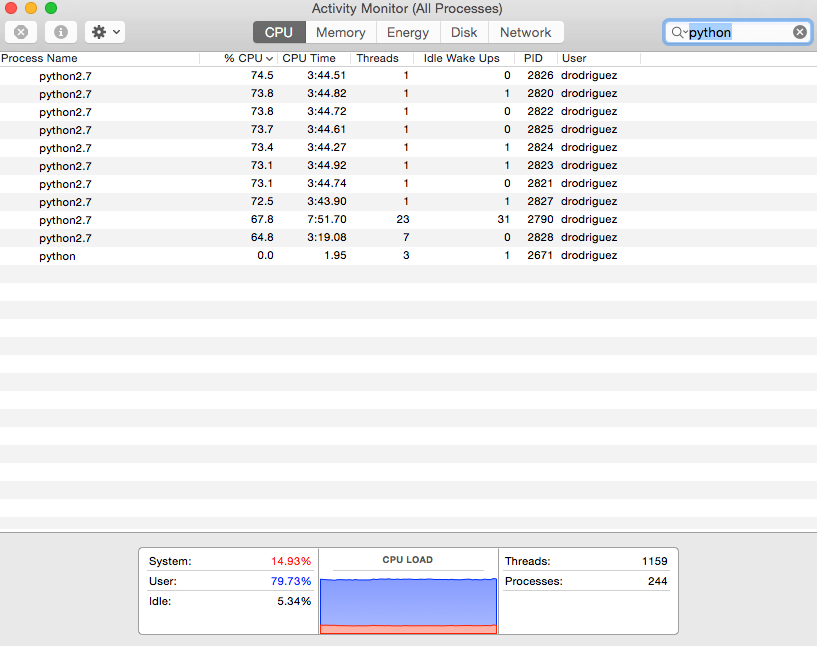
)

In [10]:
start_time = time.time()

values = counts.compute()

elapsed_time = time.time() - start_time

We can see how long the computation took, in this case: around 23 minutes which is about 1.4 GB per minute.

In [11]:
elapsed_time  # seconds

1416.4745790958405

With the word count done we can just sort the python list and see the most common words.

In [12]:
len(values)

84672

In [13]:
sort = sorted(values, key=lambda x: x[1], reverse=True)

In [14]:
sort[:100]

[(u'movie', 75848),
 (u'like', 60028),
 (u'one', 41682),
 (u'would', 37354),
 (u'think', 33539),
 (u'really', 32494),
 (u'film', 30931),
 (u'movies', 30196),
 (u'people', 30046),
 (u'good', 27207),
 (u'see', 25992),
 (u'time', 22783),
 (u'get', 21364),
 (u'much', 20097),
 (u'even', 19977),
 (u'deleted', 19464),
 (u'could', 19338),
 (u'know', 19275),
 (u'first', 18435),
 (u'well', 18155),
 (u'also', 17935),
 (u'great', 16729),
 (u'make', 16668),
 (u'way', 16494),
 (u'gt', 16097),
 (u'still', 15747),
 (u'pretty', 14808),
 (u'going', 14649),
 (u'made', 14630),
 (u'watch', 13648),
 (u'http', 13338),
 (u'actually', 13307),
 (u'love', 12916),
 (u'something', 12838),
 (u'never', 12762),
 (u'films', 12688),
 (u'seen', 12642),
 (u'though', 12576),
 (u'character', 12395),
 (u'thought', 12332),
 (u'say', 12320),
 (u'man', 12247),
 (u'scene', 12126),
 (u'bad', 12065),
 (u'got', 12004),
 (u'thing', 11895),
 (u'lot', 11864),
 (u'go', 11792),
 (u'story', 11616),
 (u'better', 11599),
 (u'want', 11224)

Save a file with the results

In [17]:
with open('r_movies.txt', 'w') as f:
    for item in sort:
        f.write("%s %i\n" % item)

## Conclusions

This was a simple post making some computation on 33 GB of data in a single node using around 20 lines of python. The main objective was to reproduce some of the results other people have made with bigger tools like Google Big Query with simpler but also powerful tools in a single node. Also I used dask for the first time and I was kinda impressed by it.

If you have some medium size data a big workstation and dont want to mess up with clusters you should checkout [dask](https://github.com/ContinuumIO/dask). You can also use dask in a cluster but lets save that for a diffent post.